In [14]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.6.0


'3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]'

In [15]:
!pip install -U tensorflow-addons

In [16]:
!pip install wheel
!pip install pandas
!pip install opencv-python
!pip install matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [84]:
train_path = "./Downloads/Final_Train_Test_thesis2.0/train"
test_path = "./Downloads/Final_Train_Test_thesis2.0/test"
x_train=[]  

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(128,128))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(128,128))

        x_test.append(img_arr)

In [85]:
x_train=np.array(x_train)
x_test=np.array(x_test)

In [86]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [87]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 500,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 500,
                                            class_mode = 'sparse')

Found 9921 images belonging to 3 classes.
Found 1420 images belonging to 3 classes.


In [88]:
y_train=training_set.classes
y_test=test_set.classes

In [89]:
NUM_CLASSES = 4
INPUT_SHAPE = (128, 128, 3)


print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (9921, 128, 128, 3) - y_train shape: (9921,)
x_test shape: (1420, 128, 128, 3) - y_test shape: (1420,)
x_train shape: (9921, 128, 128, 3) - y_train shape: (9921, 1)
x_test shape: (1420, 128, 128, 3) - y_test shape: (1420, 1)


In [90]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 500
num_epochs = 200
image_size = 128  # We'll resize input images to this size
patch_size = 16   # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [91]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


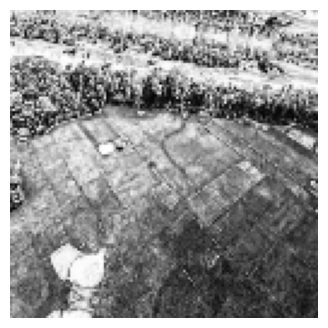

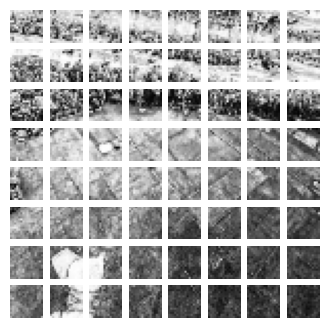

In [92]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [93]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.05)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "Downloads/final_datasets"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [94]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/200
16/16 [==============================] - 14s 239ms/step - loss: 2.4220 - accuracy: 0.4956 - top-5-accuracy: 1.0000 - val_loss: 1.8463 - val_accuracy: 0.0217 - val_top-5-accuracy: 1.0000
Epoch 2/200
16/16 [==============================] - 3s 168ms/step - loss: 0.6769 - accuracy: 0.7030 - top-5-accuracy: 1.0000 - val_loss: 1.6496 - val_accuracy: 0.1819 - val_top-5-accuracy: 1.0000
Epoch 3/200
16/16 [==============================] - 3s 167ms/step - loss: 0.5553 - accuracy: 0.7692 - top-5-accuracy: 1.0000 - val_loss: 2.0680 - val_accuracy: 0.1662 - val_top-5-accuracy: 1.0000
Epoch 4/200
16/16 [==============================] - 3s 169ms/step - loss: 0.4966 - accuracy: 0.7960 - top-5-accuracy: 1.0000 - val_loss: 1.6327 - val_accuracy: 0.4403 - val_top-5-accuracy: 1.0000
Epoch 5/200
16/16 [==============================] - 3s 168ms/step - loss: 0.4147 - accuracy: 0.8308 - top-5-accuracy: 1.0000 - val_loss: 1.5769 - val_accuracy: 0.5048 - val_top-5-accuracy: 1.0000
Epoch 6/200
16

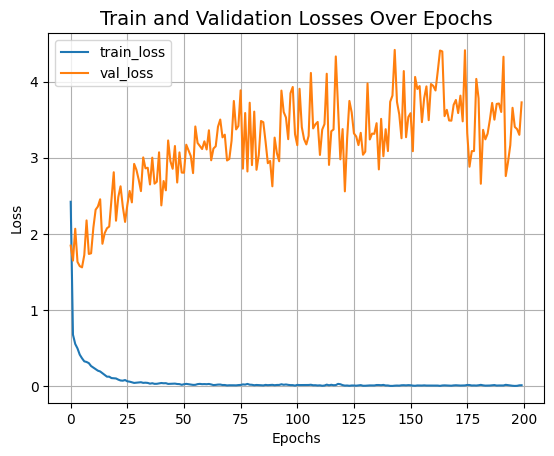

In [95]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

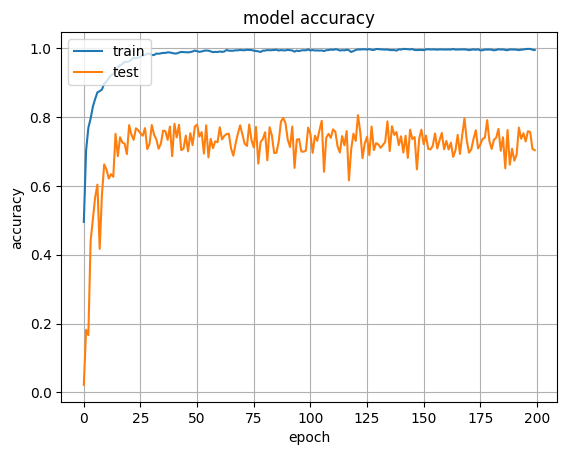

In [96]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [97]:
# p = Augmentor.Pipeline("3D Objects/raw/",output_directory="../New_folder")
# #Step 3 Define the Operations
# p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
# p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
# p.sample(800)

import pathlib
import tensorflow as tf

data_dir = pathlib.Path('./Downloads/Final_Train_Test_thesis2.0/train')

img_height=128
img_width=128


train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=500)

Found 9921 files belonging to 3 classes.
Using 7937 files for training.


In [98]:

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

normalization_layer = tf.keras.layers.Rescaling(1./255)


import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9921 files belonging to 3 classes.
Using 1984 files for validation.
0.004901961 1.0


In [99]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(7937,)
(1984,)


In [100]:
import scipy
# if this works
from scipy.sparse import issparse

In [101]:
!pip install scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = vit_classifier.predict_generator(val_ds, 700)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['Flood', 'Flood_with_habitation', 'No_Flood']
#target_names = ['Normal','Glocoman']
print(classification_report(test_label, y_pred, target_names=target_names))

C:\Users\20101621\.conda\envs\new_env\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[652   1   2]
 [  0 717   0]
 [ 57  19 536]]
Classification Report
                       precision    recall  f1-score   support

                Flood       0.92      1.00      0.96       655
Flood_with_habitation       0.97      1.00      0.99       717
             No_Flood       1.00      0.88      0.93       612

             accuracy                           0.96      1984
            macro avg       0.96      0.96      0.96      1984
         weighted avg       0.96      0.96      0.96      1984



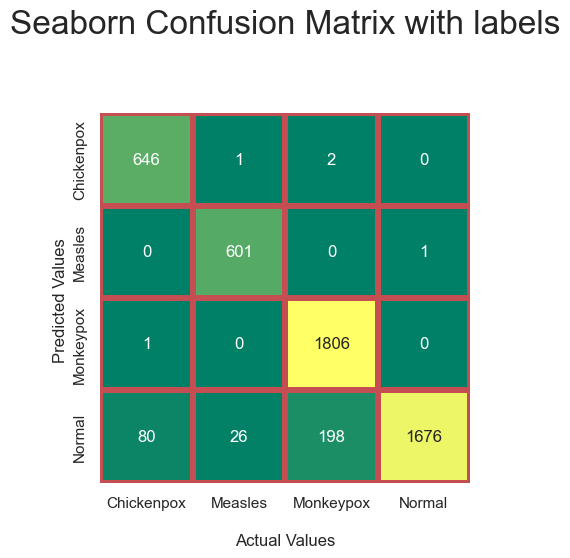

In [ ]:
!pip install seaborn
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');